In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

### The Big Problem

Suppose you want to monitor events occurring on the seafloor. Examples include detecting volcanic activity, identifying pipeline failures, or monitoring undersea communication cables. Doing so requires deploying instruments on the seafloor that can detect events and report them back to the surface. This setting imposes several key constraints and objectives:

1. **Latency.** Detections should be reported to the surface as quickly as possible. You can't just wait a year and then look at the recordings. 

2. **Energy preservation.** Each sensor has a limited battery and must be replaced when depleted, imposing a cost per unit of energy used, which could be quite high for communication via sonar.

3. **Surface access.** Only one or two sensors can be connected to the surface via cable.

4. **Communication range.** There is a maximum reliable wireless communication distance $d$ between sensors.

5. **Signal attenuation.** Event signal strength decays with distance.

6. **Event model.** Each event occurs once, at a single unknown location.

7. **Local knowledge.** Each sensor knows its own location.

Under these constraints, the problem is to design a network of sensors and a set of communication protocols that reliably detect events and report them to the surface, while maximizing utility.

### Signal propogation and the noise model

Let the distance from the event to some sensor be $d$ and the speed of sound be $\lambda$. Let $n(t)$ be the background noise for the sensor at time $t$. Say the event occurs at $t_0$. The sensor will get:

$$ s = s(d) h(t - t_0 - \frac{d}{\lambda}) + n(t) $$

Where $h$ is the waveform of the event. For instance:

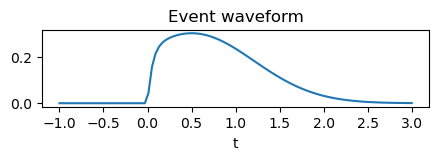

In [2]:
def h(t):
    return (t>0) * np.exp(-(t-0.5)**2) * (1 - np.exp(-20*t)) * 0.3
    #return (t>0) * (t<1) # for testing

event_length = 3

t = np.linspace(-1,event_length,100)
plt.figure(figsize=(5,1))
plt.plot(t,h(t))
plt.xlabel("t")
plt.title("Event waveform")
plt.show()

And $s(d)$ is the decay in signal strength with distance. Physicists look at this, but I'll just use a basic decaying function e.g.,

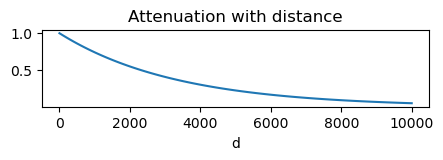

In [3]:
def s(d):
    return np.exp(-d*0.0003)

d = np.linspace(0,10000,100)
plt.figure(figsize=(5,1))
plt.plot(d,s(d))
plt.xlabel("d")
plt.title("Attenuation with distance")
plt.show()

At a distance of 4 km the signal is mostly gone.

For the noise we can use a per-sensor Ornstein–Uhlenbeck process, which is more realistic than random noise.

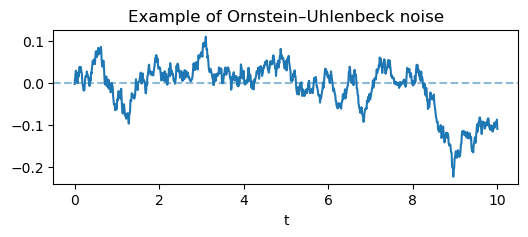

In [4]:
def ou_process(dt, steps):
    x = 0
    results = []
    for i in range(steps):
        x = x - 0.5 * x * dt + 0.1 * np.sqrt(dt) * np.random.normal()
        results.append(x)
    return np.array(results)

plt.figure(figsize=(6,2))
plt.plot(np.linspace(0,10,1000),ou_process(0.01,1000))
plt.axhline(0, linestyle="--", alpha=0.5)
plt.xlabel("t")
plt.title("Example of Ornstein–Uhlenbeck noise")
plt.show()

Putting these together we can get a model of the signal with the event occuring:

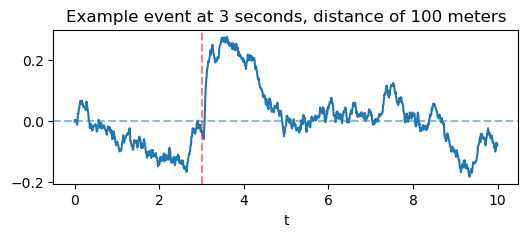

In [5]:
speed_of_sound = 1500

def sensor_signal(dt, steps, event_time, event_pos, sensor_pos):
    distance = np.linalg.norm(sensor_pos - event_pos)
    delay = distance / speed_of_sound
    background = ou_process(dt, steps)
    attenuated_strength = s(distance)
    t = np.arange(steps) * dt
    event_signal = h(t - event_time - delay)
    return attenuated_strength * event_signal + background

example = sensor_signal(0.01, 1000, 3, np.zeros(2), np.array([0,100])) # 100 meters away
t = np.arange(1000)*0.01
plt.figure(figsize=(6,2))
plt.plot(t, example)
plt.axhline(0, linestyle="--", alpha=0.5)
plt.axvline(3, linestyle="--", alpha=0.5, color="red")
plt.xlabel("t")
plt.title("Example event at 3 seconds, distance of 100 meters")
plt.show()

And finally we can make a collection of sensors to do this:

In [6]:
def make_sensor_grid(rows, cols, spacing):
    xs = np.arange(cols) * spacing
    ys = np.arange(rows) * spacing
    xs = xs - xs.mean()
    ys = ys - ys.mean()
    X, Y = np.meshgrid(xs, ys)
    sensors = np.column_stack([X.ravel(), Y.ravel()])
    return sensors

def all_sensor_signals(dt, steps, event_time, event_pos, sensors):
    signals = [sensor_signal(dt, steps, event_time, event_pos, sensor_pos) for sensor_pos in sensors]
    return np.array(signals)

def visualize_array_and_signals(sensors, event_pos, signals, dt):
    num_sensors, steps = signals.shape
    t = np.arange(steps) * dt
    fig, (ax_space, ax_time) = plt.subplots(
        1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 2]}
    )
    
    ax_space.scatter(
        event_pos[0], event_pos[1],
        color="black", s=80, marker="*", label="Event"
    )
    ax_space.set_aspect("equal")
    ax_space.set_xlabel("x (m)")
    ax_space.set_ylabel("y (m)")
    ax_space.legend()
    ax_space.set_title("Sensor layout")

    for i in range(num_sensors):
        ax_space.scatter([sensors[i][0]], [sensors[i][1]])
        ax_time.plot(t, signals[i], alpha=0.7)

    ax_time.axhline(0, linestyle="--", color="gray", alpha=0.5)
    ax_time.set_xlabel("t (s)")
    ax_time.set_title("Received signals")

    plt.tight_layout()
    plt.show()

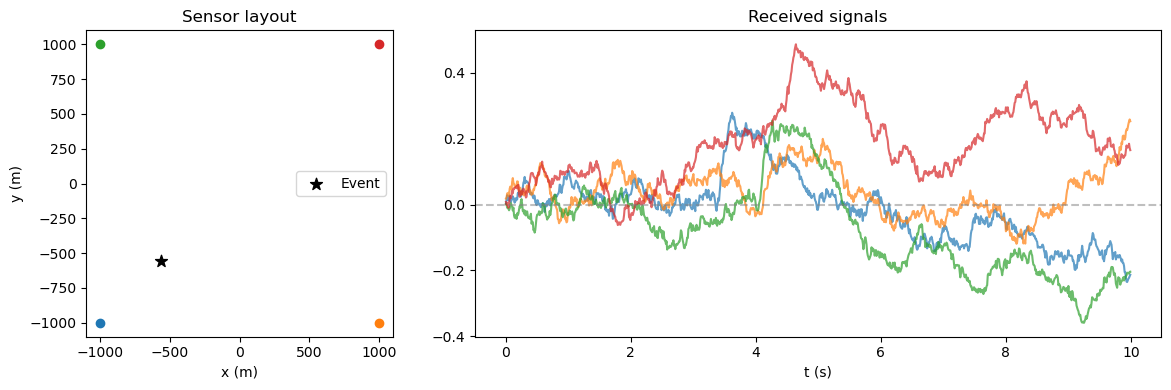

In [7]:
dt = 0.01
steps = 1000
t = np.arange(steps)*dt
sensors = make_sensor_grid(rows=2, cols=2, spacing=2000)
event_pos = np.random.uniform(sensors.min(axis=0), sensors.max(axis=0))
event_time = 3
signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
visualize_array_and_signals(sensors, event_pos, signals, dt)

Fantastic, now we can simulate a bunch of nodes receiving a signal. The next step is to do inference by combining information.

### Inference with no communication cost

If we know the position where the event came from one thing we could do is match up the resulting signals by shifting each response according to the delay. Then adding all the signals together we should see the event clearly. E.g.,

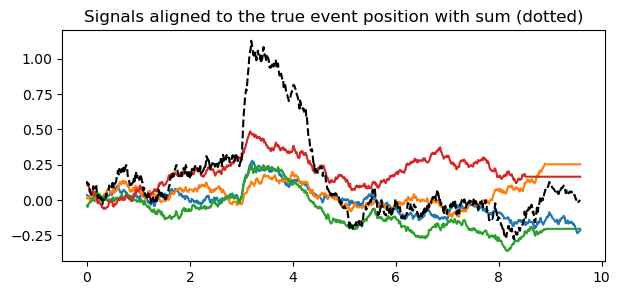

In [8]:
def shift_with_delay(sensors, signals, event_location, dt, speed_of_sound):
    aligned = []

    for i in range(len(sensors)):
        distance = np.linalg.norm(sensors[i] - event_location)
        delay = distance / speed_of_sound
        delay_in_steps = int(delay / dt)
        aligned.append(signals[i][delay_in_steps:])

    max_len = max(len(a) for a in aligned)
    out = np.empty((len(sensors), max_len), dtype=float)

    for i, a in enumerate(aligned):
        out[i, :len(a)] = a
        out[i, len(a):] = a[-1]   # ← pad with last value

    return out

aligned_signals = shift_with_delay(sensors, signals, event_pos, dt, speed_of_sound)

plt.figure(figsize=(7,3))
for i in range(len(sensors)):
    plt.plot(np.arange(aligned_signals.shape[1])*dt,aligned_signals[i])
plt.plot(np.arange(aligned_signals.shape[1])*dt,np.sum(aligned_signals,axis=0), color="black", linestyle="--")
plt.title("Signals aligned to the true event position with sum (dotted)")
plt.show()                    

As you can see there is a spike at exactly 3 seconds and the tail follows our event waveform. 

We then take this curve and then extract the best correlation knowing the event waveform, using convolution:

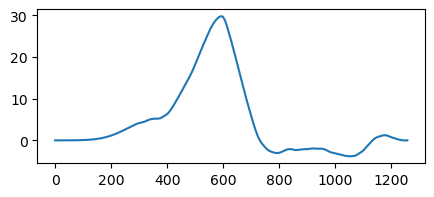

In [9]:
h_array = h(np.arange(int(event_time/dt))*dt)
convolved = np.convolve(np.sum(aligned_signals,axis=0), h_array[::-1])
plt.figure(figsize=(5,2))
plt.plot(convolved)
#plt.xticks([])
plt.show()

The peak of this curve is the maximum correlation between the delay-corrected signals and the event waveform. This value should be much higher for true events. 

Now we don't actually know the position of the event so we will also need to maximize this value over possible locations. Essentially we will calculate the highest value of this correlation across the unknown possible event locations and then use that value for classification with a threshold.

We first do the location:

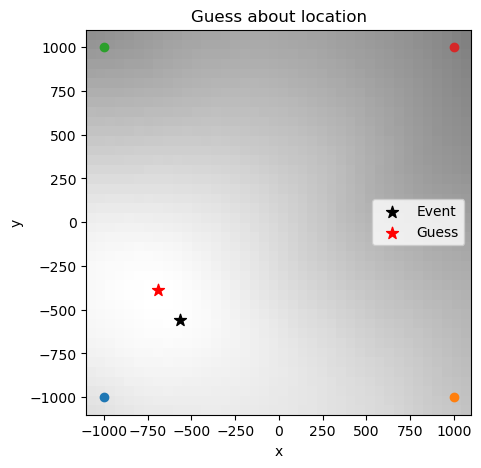

In [10]:
def get_score_grid(sensors, signals, dt, speed_of_sound):
    xs = np.linspace(np.min(sensors[:, 0]), np.max(sensors[:, 0]), 40)
    ys = np.linspace(np.min(sensors[:, 1]), np.max(sensors[:, 1]), 40)
    score_grid = np.zeros((len(xs), len(ys)))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            candidate_pos = np.array([x, y])
            aligned_signals = shift_with_delay(sensors, signals, candidate_pos, dt, speed_of_sound)
            correlation = np.convolve(np.sum(aligned_signals,axis=0), h_array[::-1])
            score_grid[i, j] = np.max(correlation)
    return xs, ys, score_grid

def plot_score_grid(xs, ys, score_grid, sensors):
    flat_idx = np.argmax(score_grid)
    i_max, j_max = np.unravel_index(flat_idx, score_grid.shape)
    plt.figure(figsize=(6, 5))
    plt.imshow(score_grid.T, origin="lower", extent=[xs[0]-100, xs[-1]+100, ys[0]-100, ys[-1]+100], cmap="grey", alpha=0.5)
    for i in range(len(sensors)):
        plt.scatter([sensors[i][0]], [sensors[i][1]])
    plt.scatter(event_pos[0], event_pos[1], color="black", s=80, marker="*", label="Event")
    plt.scatter(xs[i_max], ys[j_max], color="red", s=80, marker="*", label="Guess")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Guess about location")
    plt.show()

xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
plot_score_grid(xs, ys, score_grid, sensors)

Great! Even with just 4 noisy signals we can guess the position roughly using this method. And a few more sensors won't hurt either.

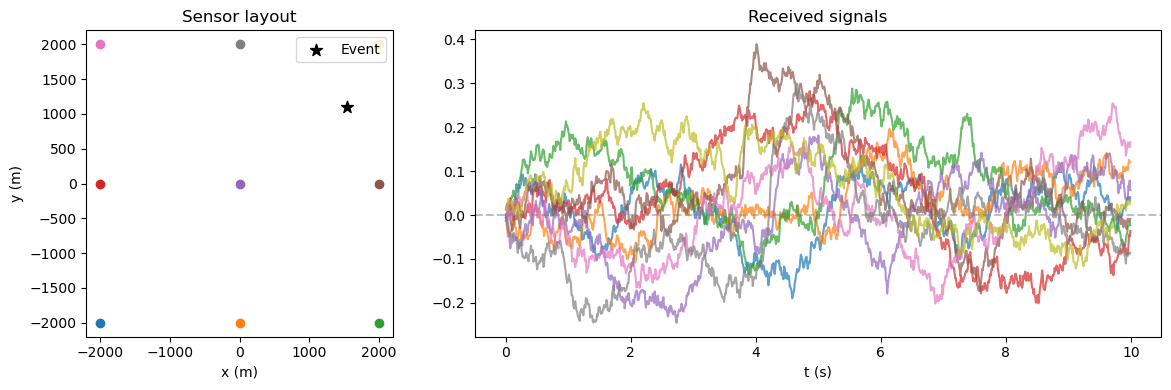

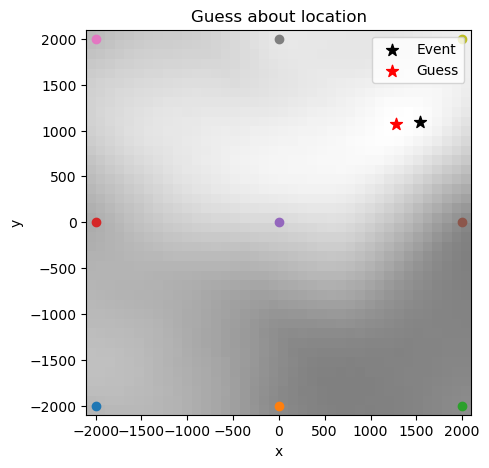

In [11]:
sensors = make_sensor_grid(rows=3, cols=3, spacing=2000)
event_pos = np.random.uniform(sensors.min(axis=0), sensors.max(axis=0))
signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
visualize_array_and_signals(sensors, event_pos, signals, dt)
xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
plot_score_grid(xs, ys, score_grid, sensors)

Now the only thing left to do is to determine whether an event has occured:

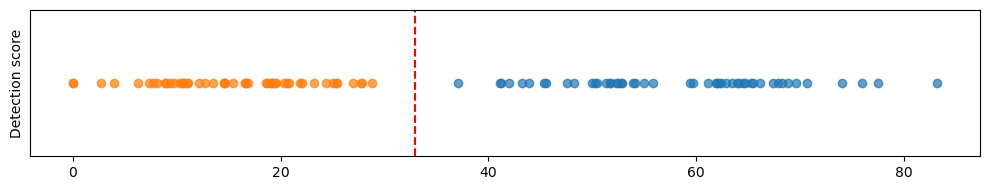

Best threshold: 32.95
Accuracy at best threshold: 1.0


In [12]:
dt = 0.01
steps = 1000
t = np.arange(steps) * dt
sensors = make_sensor_grid(rows=3, cols=3, spacing=1000)

event_scores = []
for sample in range(50):
    event_time = np.random.rand() * t[-int(event_length/dt)]
    event_pos = np.random.uniform(sensors.min(axis=0), sensors.max(axis=0))
    signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
    xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
    event_scores.append(np.max(score_grid))

no_event_scores = []
for sample in range(50):
    signals = [ou_process(dt, steps) for _ in range(len(sensors))]
    xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
    no_event_scores.append(np.max(score_grid))

event_scores = np.array(event_scores)
no_event_scores = np.array(no_event_scores)

scores = np.concatenate([event_scores, no_event_scores])
labels = np.concatenate([
    np.ones(len(event_scores)),      # event = 1
    np.zeros(len(no_event_scores))   # no event = 0
])

order = np.argsort(scores)
scores_sorted = scores[order]
labels_sorted = labels[order]

# Thresholds are midpoints between consecutive scores
thresholds = (scores_sorted[:-1] + scores_sorted[1:]) / 2

best_acc = -1
best_thresh = None

for th in thresholds:
    preds = (scores >= th).astype(int)
    acc = np.mean(preds == labels)
    if acc > best_acc:
        best_acc = acc
        best_thresh = th

plt.figure(figsize=(10, 2))
plt.scatter(event_scores, np.zeros(len(event_scores)), alpha=0.7, label="Event")
plt.scatter(no_event_scores, np.zeros(len(no_event_scores)), alpha=0.7, label="No event")
plt.axvline(best_thresh, color="red", linestyle="--",
            label=f"Best threshold = {best_thresh:.3f}")
plt.ylabel("Detection score")
plt.yticks([])
plt.tight_layout()
plt.show()


print("Best threshold:", round(best_thresh, 2))
print("Accuracy at best threshold:", round(best_acc, 2))

Great! This gives us a very high accuracy. To summarise what we are doing is maximising over possible event positions and possible event times the correlation between the event waveform and the sum of delay-corrected signals at that time. This gives us a number which we can use for classification. 

This is a nice start. However, it's very communication-heavy. Every sensor needs to send its entire data back to some central node in order to compute the alignment scores. While you could have a hierachy, where each node adds up the signal from its children, this still means every node except the root sending a value to another node at every timestep.

### Inference with communication costs

One option is to just have each node output whether something has happened, and then check if at least $r$ nodes have been triggered. We then just need to search for the threshold for saying whether a node is triggered.

In [13]:
event_per_sensor_max = []
for sample in range(50):
    event_time = np.random.rand()*t[-int(event_length/dt)]
    event_pos = np.random.uniform(sensors.min(axis=0), sensors.max(axis=0))
    signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
    correlations = [np.convolve(signals[i], h_array[::-1]) for i in range(len(sensors))]
    max_correlations = [np.max(c) for c in correlations]
    event_per_sensor_max.append(max_correlations)

event_per_sensor_max = np.array(event_per_sensor_max)

no_event_per_sensor_max = []
for sample in range(50):
    signals = [ou_process(dt, steps) for i in range(len(sensors))]
    xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
    correlations = [np.convolve(signals[i], h_array[::-1]) for i in range(len(sensors))]
    max_correlations = [np.max(c) for c in correlations]
    no_event_per_sensor_max.append(max_correlations)

no_event_per_sensor_max = np.array(no_event_per_sensor_max)

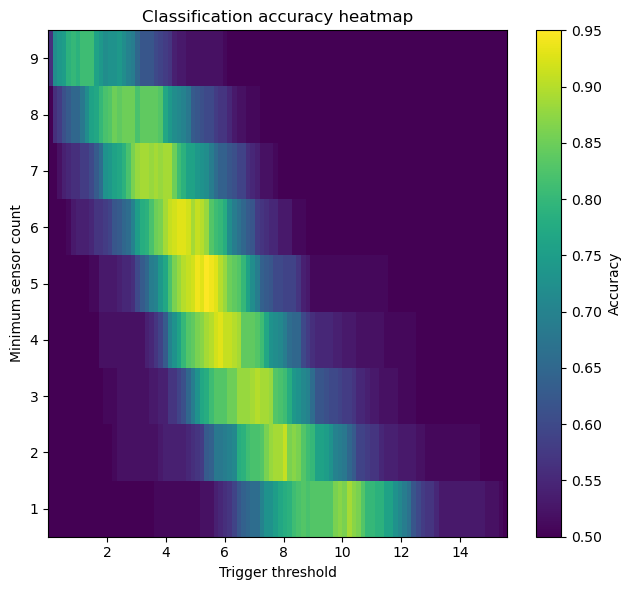

Peak Accuracy of 0.95 with threshold 5 and count 5


In [14]:
trigger_points = np.linspace(np.min(event_per_sensor_max), np.max(event_per_sensor_max), 100)
num_sensors = event_per_sensor_max.shape[1]
accuracy_grid = np.zeros((num_sensors, len(trigger_points)))
num_event_samples = event_per_sensor_max.shape[0]
num_no_event_samples = no_event_per_sensor_max.shape[0]
total_samples = num_event_samples + num_no_event_samples

best_accuracy = 0
best_point = []
for j, trigger in enumerate(trigger_points):
    event_count = np.sum(event_per_sensor_max > trigger, axis=1)
    no_event_count = np.sum(no_event_per_sensor_max > trigger, axis=1)
    for minimum_count in range(1, num_sensors + 1):
        true_positives = np.sum(event_count >= minimum_count)
        true_negatives = np.sum(no_event_count < minimum_count)
        accuracy = (true_positives + true_negatives) / total_samples
        accuracy_grid[minimum_count - 1, j] = accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_point = [trigger, minimum_count]

plt.figure(figsize=(6.5, 6))
im = plt.imshow(accuracy_grid, aspect='auto', origin='lower', extent=[trigger_points[0], trigger_points[-1], 0.5, num_sensors + 0.5])
plt.colorbar(im, label='Accuracy')
plt.xlabel('Trigger threshold')
plt.ylabel('Minimum sensor count')
plt.title('Classification accuracy heatmap')
plt.yticks(np.arange(1, num_sensors + 1))
plt.tight_layout()
plt.show()

print("Peak Accuracy of", best_accuracy, "with threshold", round(best_point[0]), "and count", best_point[1])


Nice! And we still get a reasonable accuracy with this. It's interesting seeing the trade-off between a single strong trigger and lots of weaker ones.  

This gives us a handy minimal-communication method. Every node just needs to send to its parent a single ping if it has been triggered, or if one of its children has been. Then the parent node receives pings over time and just needs to determine whether a sufficent number of them have happened in a short enough period of time to predict an event has occurred. 

Of course, this is *very* minimal. There are bound to be options where each node communicates it
s peak value every $x$ seconds, or sends some other summary of the recent signal. 